# Boosted decision trees and interpretable models

`xgboost` is one of the most popular Machine Learning models (for example, in ML competitions). It isn't based on a model of our neurons, but on a much simpler idea: decision trees.

A decision tree is a tree-like algorithm, i.e. a flowchart with no loops, in which the input data is subdivided in categories according to a series of binary (yes/no) splittings. These splittings are selected by succesively sub-dividing the training data along the boundaries that minimize the number of mis-identified data-points:

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*1FNXYP8CBVRYR9jS7Fy6vA.png)
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*tSkXBEMb8SK9oyUUBqO3dw.png)
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KxFRvEN57uDTzmA4458eLA.png)


A decision tree becomes a regression tree if each category is associated to a real number.

![](regtree.png)

Thus, a regression tree defines a function $f: \mathbb{R}^n \to \mathbb{R}$. However, this function is rather simple, an can not reproduce arbitrary functions. The solution is to take an *ensemble* of regression trees.

The simplest way to do this is called a *random forest*. In a random forest algorithm, the training data is sampled to train multiple trees (with replacement, so a datapoint can be used to train several trees). Additionally, each tree is allowed to use only a random subset of the features for the splittings, in order to reduce the correlation between trees. The prediction of all the trees of the ensemble is averaged to obtain the prediction of the model.

An improved algorithm is *tree boosting*. Starting with an ensemble with zero trees, it adds at each iteration the tree taht most improves the cost function (*greedy optimization*).

`xgboost` ([arXiv:1603.02754](https://arxiv.org/abs/1603.02754)) is a regularized tree boosting algorithm. "Regularized" means that the cost function is calculated as the sum of two functions: the loss function, that penalizes predictions that are far away from the true values, and the complexity function, that penalizes trees with extreme values of the nodes of the trees.

In [32]:
import xgboost
import pandas as pd
import random
import numpy as np

`xgboost` uses a class called `DMatrix` to store the features and labels. A `DMatrix` can be initialized from lists, `numpy`'s arrays, `pandas`' dataframes, etc...

Let us create a class to represent our training and validation data. The following code reads the data from a file into a dataframe, shuffles it and splits it between training and validation, and returns the corresponding `DMatrix`.

In [2]:
class RKDataSet():
    def __init__(self, split=0.8):
        RKdata = pd.read_csv('RKwilson.dat', sep='\t', names=['C9', 'C10', 'RK'])
        self.X = RKdata[['C9', 'C10']]
        self.Y = RKdata['RK']
        self.split = split
        self.idx_tr = range(int(split*len(self)))
        self.idx_val = range(int(split*len(self)), len(self))
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def train_split(self):
        # Shuffles the data for the training/validation split
        idx = random.sample(range(len(self)), len(self))
        self.idx_tr = idx[:int(self.split*len(self))]
        self.idx_val = idx[int(self.split*len(self)):]
    def train_data(self):
        return xgboost.DMatrix(self.X.loc[self.idx_tr], self.Y.loc[self.idx_tr])
    def val_data(self):
        return xgboost.DMatrix(self.X.loc[self.idx_val], self.Y.loc[self.idx_val])

In [3]:
RKset = RKDataSet()
RKset.train_split()

We can train the `xgboost` model with the function `xgboost.train()`. It takes 3 required arguments: a dictionary with the configuration of the model, the training data and the number of boosting rounds, i.e., the (maximum) number of trees created. Some interesting configuration parameters:
* `nthread`: Number of threads for parallel training.
* `max_depth`: Maximum number of branchings in the trees.
* `device`: The option `'device': 'cuda'` moves the model to a CUDA-capable GPU.
* `objective`: Changes the cost function. The default is `reg:squarederror`, i.e., the minimum squares for regression problems. Other possible options include `reg:logistic`, `reg:absoluteerror` and `reg:poisson`, as well as functions for classification and ranking problems.

In [4]:
xb = xgboost.train({'nthread': 4, 'max_depth': 3}, RKset.train_data(), 50)

We can use the model to make a prediction with the method `predict`. The input data must be in a `DMatrix` with the same format as the training data. In our case, it must be a dataframe with the same headers.

In [5]:
def xb_prediction(C9, C10):
    return xb.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

In [6]:
xb_prediction(-0.87, 0.24)

0.76236165

Optionally, we can visualize the trees using `graphviz`. You need to install `graphviz` both as a python library (e.g. `pip install graphviz`) and as binary for your operating system (e.g. `apt install graphviz`). Let us see the 7th tree in our ensemble:

<Axes: >

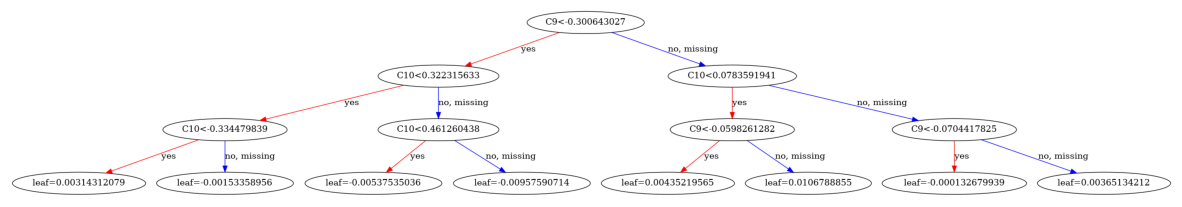

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
xgboost.plot_tree(xb, num_trees=7, ax=ax)

We are at risk of over-fitting if we train too many trees. We can see how the the cost function evolves in the training and validation datasets if we pass them with the argument `evals`. This argument has to be a list of tuples, each tuple containig the corresponding `DMatrix` and a `string` with the name of the dataset:

In [8]:
xb = xgboost.train({'nthread': 4, 'max_depth': 7}, RKset.train_data(), 50, evals=[(RKset.train_data(), 'train'), (RKset.val_data(), 'val')] )

[0]	train-rmse:0.06804	val-rmse:0.06756
[1]	train-rmse:0.04861	val-rmse:0.04841
[2]	train-rmse:0.03484	val-rmse:0.03474
[3]	train-rmse:0.02502	val-rmse:0.02521
[4]	train-rmse:0.01808	val-rmse:0.01852
[5]	train-rmse:0.01313	val-rmse:0.01392
[6]	train-rmse:0.00964	val-rmse:0.01064
[7]	train-rmse:0.00718	val-rmse:0.00839
[8]	train-rmse:0.00546	val-rmse:0.00691
[9]	train-rmse:0.00427	val-rmse:0.00594
[10]	train-rmse:0.00347	val-rmse:0.00531
[11]	train-rmse:0.00293	val-rmse:0.00490
[12]	train-rmse:0.00253	val-rmse:0.00461
[13]	train-rmse:0.00225	val-rmse:0.00440
[14]	train-rmse:0.00207	val-rmse:0.00425
[15]	train-rmse:0.00193	val-rmse:0.00415
[16]	train-rmse:0.00184	val-rmse:0.00407
[17]	train-rmse:0.00175	val-rmse:0.00400
[18]	train-rmse:0.00171	val-rmse:0.00397
[19]	train-rmse:0.00167	val-rmse:0.00393
[20]	train-rmse:0.00162	val-rmse:0.00390
[21]	train-rmse:0.00158	val-rmse:0.00388
[22]	train-rmse:0.00155	val-rmse:0.00385
[23]	train-rmse:0.00153	val-rmse:0.00384
[24]	train-rmse:0.00149	va

We also can store the evaluations in a dictionary with the argument `evals_result`. We can suppress the printing of the evaluations with `verbose_eval=0`:

In [9]:
d_eval = {}
xb = xgboost.train({'nthread': 4, 'max_depth': 7}, RKset.train_data(), 200, evals=[(RKset.train_data(), 'train'), (RKset.val_data(), 'val')], evals_result=d_eval, verbose_eval=0)

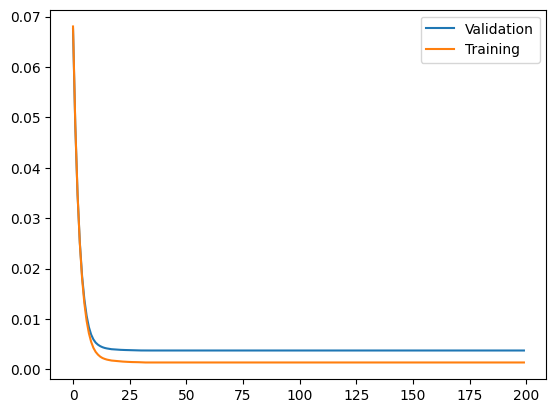

In [10]:
plt.plot(d_eval['val']['rmse'], label='Validation')
plt.plot(d_eval['train']['rmse'], label='Training')
plt.legend()

We see that the cost function at first decreases rapidly, and after that is horizontal. That is, the trees added at later stages don't help in making a better model and we are just overfitting. In order to avoid that, we can use early stopping, that stops the boosting process if the cost function doesn't improve in $n$ rounds. Important: early stopping is based on the *last* dataset passed in `evals`:

In [11]:
d_eval = {}
xb = xgboost.train({'nthread': 4, 'max_depth': 7}, RKset.train_data(), 200, evals=[(RKset.train_data(), 'train'), (RKset.val_data(), 'val')], evals_result=d_eval, verbose_eval=0, early_stopping_rounds=5)

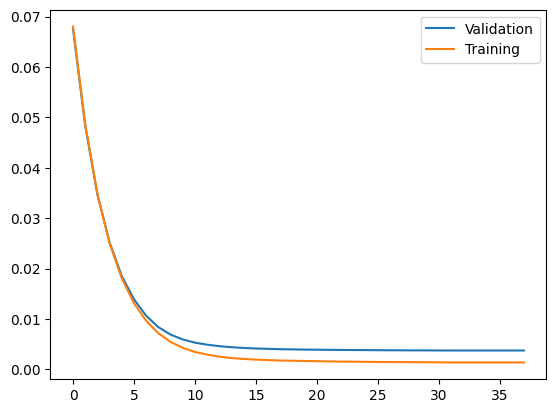

In [12]:
plt.plot(d_eval['val']['rmse'], label='Validation')
plt.plot(d_eval['train']['rmse'], label='Training')
plt.legend()

We can easily create "sub-ensembles" that containing only some of the trees of the original ensemble by slicing it. For example, let us see how the prediction changes if we only use the first five trees, or if we use only the rest:

In [13]:
xb1 = xb[0:5]
def xb1_prediction(C9, C10):
    return xb1.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

xb2 = xb[5:]
def xb2_prediction(C9, C10):
    return xb2.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

In [14]:
print(xb1_prediction(-0.84, 0.3))
print(xb2_prediction(-0.84, 0.3))

0.7722455
0.8736837


We can save the trained model in a `JSON` file:

In [15]:
xb1.save_model("xgboost_model_1.json")

and load from a `JSON`` file:

In [16]:
xb01 = xgboost.Booster(model_file="xgboost_model_1.json")
def xb01_prediction(C9, C10):
    return xb01.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

In [17]:
xb01_prediction(-0.84, 0.3)

0.7722455

## Interpreting the model

So far, our ML models behave like a "black box", in which we put some input and get some output based on some parameters that we don't know what they mean (that is true even for the polynomial regression). Can we shed some light?

`xgboost` offers three ways to measure the *importance* of each feature in the model:

* Weight importance is simply the number of times each feature appears in the nodes of the trees:

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

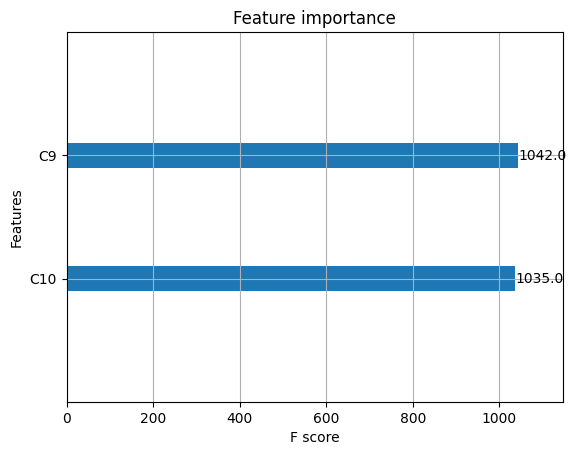

In [18]:
xgboost.plot_importance(xb, importance_type="weight")

* Gain importance is the average value gained at each split including the feature

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

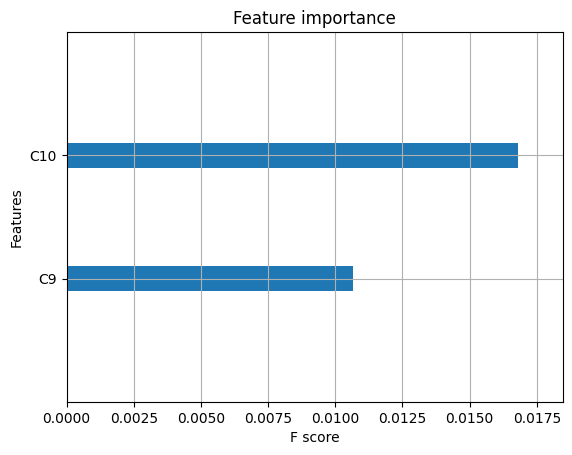

In [19]:
xgboost.plot_importance(xb, importance_type="gain", show_values=False)

* Coverage importance is the average number of times that the samples are affected by the splits of the corresponding feature.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

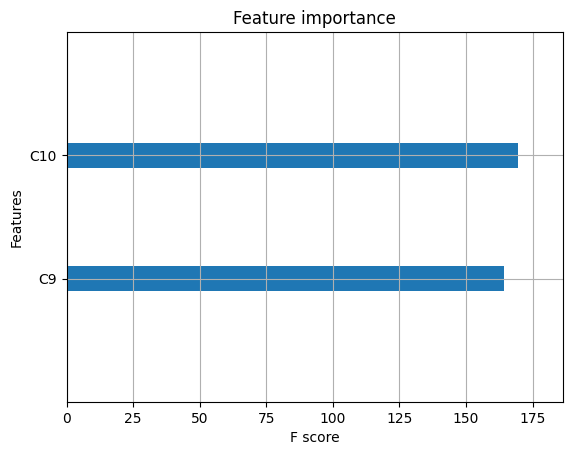

In [20]:
xgboost.plot_importance(xb, importance_type="cover", show_values=False)

We see that in our case, the ensemble of trees has the same number of $C_9$ nodes and $C_{10}$ nodes, but the dataset passes more times through $C_{10}$ nodes resulting in a greater effect in the final score.

Another measure of feature importance are the SHAP values ([arxiv:1705.07874](https://arxiv.org/abs/1705.07874)), based on an idea by Lloyd Shapley (Nobel Prize in Economics in 2012). The SHAP values split the prediction of each data point into additive contributions coming from each feature plus a constant term.

The intuitive idea is as follows: if we have $n$ features, we will train $2^n$ models on the same training dataset: one complete model, $n$ models with one missing feature, $n\choose2$ models with two missing features,... ${n\choose {n-1}} = n$ models with only one feature and finally one model with no features, i.e. the arithmetic mean of the training data.

The following diagram shows the models $\phi$ for a case with $n=3$ features:

![](shapgraph.png)

The red lines connect models that only differ in the prescence/absence of $x^1$, the green lines connect models that differ on $x^2$ and blue lines connect models that differ on $x^3$.

The SHAP value for a given value is calculated as an average (weighted by combinatoric factors) of the difference between models with and without that feature.

$$\mathrm{SHAP}_{x^1}(x^1, x^2, x^3) = \frac{1}{3}[\phi_{100}(x^1)-\phi_{000}] + \frac{1}{6}[\phi_{110}(x^1, x^2)-\phi_{010}(x^2)] + \frac{1}{6}[\phi_{101}(x^1, x^3)-\phi_{001}(x^3)] + \frac{1}{3}[\phi_{111}(x^1, x^2, x^3)-\phi_{011}(x^2, x^3)]$$
$$\mathrm{SHAP}_{x^2}(x^1, x^2, x^3) = \frac{1}{3}[\phi_{010}(x^2)-\phi_{000}]+\frac{1}{6}[\phi_{110}(x^1, x^2)-\phi_{100}(x^1)]+\frac{1}{6}[\phi_{011}(x^2, x^3)-\phi_{001}(x^3)]+\frac{1}{3}[\phi_{111}(x^1, x^2, x^3)-\phi_{101}(x^1, x^3)]$$
$$\mathrm{SHAP}_{x^3}(x^1, x^2, x^3) = \frac{1}{3}[\phi_{001}(x^3)-\phi_{000}]+\frac{1}{6}[\phi_{101}(x^1, x^3)-\phi_{100}(x^1)]+\frac{1}{6}[\phi_{011}(x^2, x^3)-\phi_{010}(x^2)]+\frac{1}{3}[\phi_{111}(x^1, x^2, x^3)-\phi_{110}(x^1, x^2)]$$

$$\phi_{111}(x^1, x^2, x^3) = \phi_{000} + \mathrm{SHAP}_{x^1}(x^1, x^2, x^3) + \mathrm{SHAP}_{x^2}(x^1, x^2, x^3) + \mathrm{SHAP}_{x^3}(x^1, x^2, x^3)$$

Having to train $2^n$ models, when $n$ is high, is usually impractical or impossible. Luckily, for ML models based in trees (random forest, `xgboost`), there exists [an algorithm](https://rdcu.be/b0z70) that can calculate the SHAP values in polynomial time without re-training, based on transversing the trees using different paths.

In [21]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [58]:
explainer = shap.TreeExplainer(xb, feature_names=['C9', 'C10'])

[13:17:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Let us see the SHAP explanation for the point $C_9=-0.84$, $C_{10}=-0.3$:

In [59]:
s1 = explainer([[-0.84, -0.4]])

In [60]:
s1.base_values

array([0.8956675], dtype=float32)

In [61]:
np.mean(RKset.train_data().get_label())

0.89566755

The base value for our `xgboost` model is $R_K=0.8956$, which is the arithmetic mean of the training data

In [62]:
s1.values

array([[-0.0695335 ,  0.10053684]], dtype=float32)

The value of $C_9$ decreases the prediction for $R_K$, while the value of $C_{10}$ increases it. Of course, the sum of the SHAP values and the base value reproduces the `xgboost` prediction:

In [63]:
xb_prediction(-0.84, -0.4)

0.92667073

In [64]:
np.sum(s1.values)+s1.base_values[0]

0.92667085

The *waterfall plot* shows how each feature contributes to the value of the prediction:

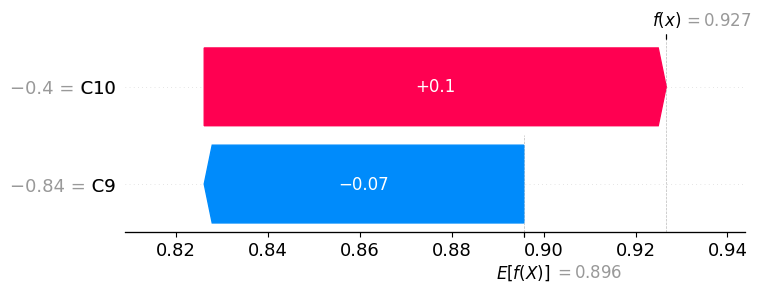

In [65]:
shap.plots.waterfall(s1[0])

With the *scatter plot* we can see the relation between the features and their corresponding SHAP values for all points in a dataset (in this case, the validation dataset):

In [72]:
shapval = explainer(RKset.val_data().get_data().toarray())

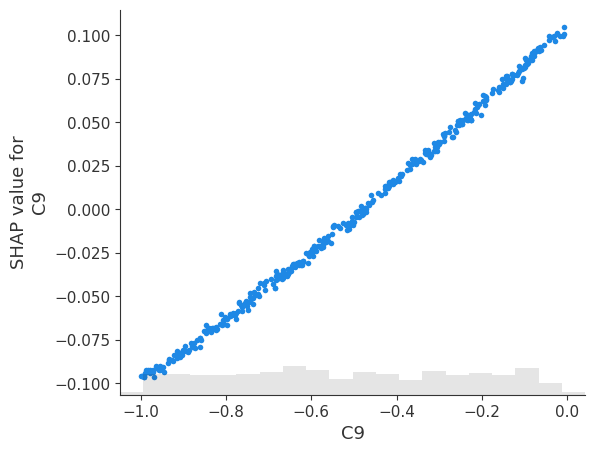

In [73]:
shap.plots.scatter(shapval[:, "C9"])

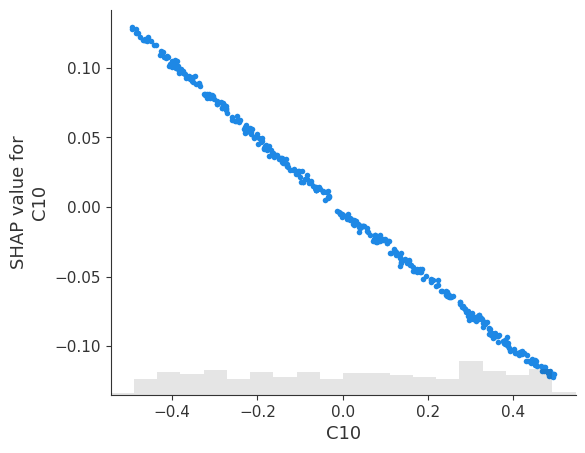

In [74]:
shap.plots.scatter(shapval[:, "C10"])

This result shouldn't surprise us. We know that the exact relation is given by the polynomial model
$$f(C_9, C_{10}; \beta) = \beta_0 + \beta_1 C_9 + \beta_2 C_{10} + \beta_3 C_9^2 + \beta_4 C_{10}^2$$

and the SHAP values reproduce this model, $\mathrm{SHAP}_{C_9} = \beta_1 C_9 + \beta_3 C_9^2$; $\mathrm{SHAP}_{C_{10}} = \beta_2 C_{10} + \beta_4 C_{10}^2$. In general, the dependence will be more complicated.

The *beeswarm plot* compares the SHAP values for all features. The $x$-axis represents the SHAP value and the $y$-axis its frequency in the dataset, with color representing the value of the feature. 

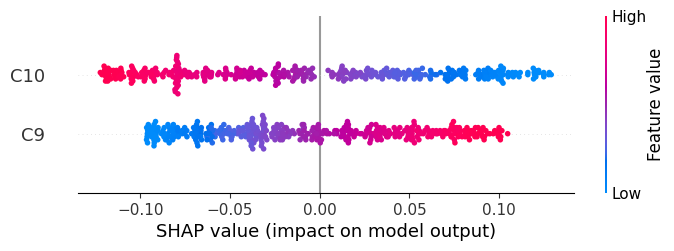

In [75]:
shap.plots.beeswarm(shapval)

In this case, we see that $C_{10}$ produces SHAP values more extreme that $C_9$, but both features are in general important to describe the data.